<a href="https://colab.research.google.com/github/DerekGloudemans/2D-Truss-Optimization/blob/master/2D_Slice_Segmentation_Weighted_Loss_Mulitclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

import ipywidgets
import traitlets

     |████████████████████████████████| 112kB 4.8MB/s 


In [0]:
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
import torchvision.transforms.functional as FT
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import nibabel as nib



## Define Dataset for Dealing with NIfTI Files
(1) spleen
(2) right kidney
(3) left kidney
(4) gallbladder
(5) esophagus
(6) liver
(7) stomach
(8) aorta
(9) inferior vena cava
(10) portal vein and splenic vein
(11) pancreas
(12) right adrenal gland
(13) left adrenal gland

In [0]:
class Nifti_Dataset(data.Dataset):
  def __init__(self,mode = "view",dim = 2):
    """
    Save the last 0.15 proportion of files after sorting for use as validation set.
    Loads each slice of the input images as a separate image
    mode - view,train or val, defined in same dataset to maintain data separation
      view - performs transforms but does not normalize images
      train - normalizes data and performs transforms
      val - normalizes data, no augmenting transforms
    dim - specifies dimension along which to slice image
    """

    self.mode = mode
    self.dim = dim

    data_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/img"
    label_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/label"

    # get all data and label file names
    self.data_files = []
    for file in os.listdir(data_dir):
      self.data_files.append(os.path.join(data_dir,file))
    self.data_files.sort()

    self.label_files = []
    for file in os.listdir(label_dir):
      self.label_files.append(os.path.join(label_dir,file))
    self.label_files.sort()

    # for each data_file
    self.train_data = []
    self.val_data = []

    for i in range(len(self.data_files)):
      data = nib.load(self.data_files[i])
      data = np.array(data.get_fdata())

      label = nib.load(self.label_files[i])
      label = np.array(label.get_fdata()).astype(float)

      identifier = self.data_files[i].split("_")[0]
      for slice in range(0,data.shape[dim]):

        # get slices
        if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
        elif dim == 1:
          data_slice = data[:,slice,:]
          label_slice = label[:,slice,:]
        elif dim == 2:
          data_slice = data[:,:,slice]
          label_slice = label[:,:,slice]

        mean,std = np.mean(data_slice),np.std(data_slice)
        # define item dict to store info
        item = {
            "identifier":identifier,
            "slice":slice,
            "data":data_slice,
            "label":label_slice,
            "mean":mean,
            "std":std
            }

        # check to make sure this example actually has organs in it
        test = np.bincount(label_slice.astype(int).reshape(-1))
        if len(test) == 1 or test[1] == 0:
          continue

        # assign to either training or validation data
        if i < len(self.data_files) * 0.85:
          self.train_data.append(item)
        else:
          self.val_data.append(item)

      #break # to shorten loading time

    # define some transforms for training dataset
    self.train_transforms = transforms.Compose([
          transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(p=0.15, scale=(0.04, 0.6), ratio=(0.3, 3.3), value=0, inplace=False), # big
          transforms.RandomErasing(p=0.3, scale=(0.01, 0.3), ratio=(0.3, 3.3), value=0, inplace=False), # medium
          transforms.RandomErasing(p=0.4, scale=(0.005, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),# small
          transforms.RandomErasing(p=0.35, scale=(0.005, 0.2), ratio=(0.3, 3.3), value=0, inplace=False) # small
          

        ])

  def __getitem__(self,index):
      #get relevant dictionary from self memory

      if self.mode in ['train','view']:
        item = self.train_data[index]
      else:
        item = self.val_data[index]

      x = Image.fromarray(item['data']).copy()
      y = Image.fromarray(item['label']).copy()

      # to grayscale
      x  = FT.to_grayscale(x)
      y = FT.to_grayscale(y)

      if self.mode in ['train','view']:
        # randomly flip and rotate both
        FLIP = 0 # np.random.rand()
        if FLIP > 0.5:
          x = FT.hflip(x)
          y = FT.hflip(y)

        ROTATE = np.random.rand()*60 - 30
        x  = x.rotate(ROTATE)
        y = y.rotate(ROTATE,Image.NEAREST)

      # resize to 224 on shorter dimension
      x = FT.resize(x, 256)
      y = FT.resize(y,256,Image.NEAREST)

      if self.mode in ['train','view']:
        # randomly jitter color of data and randomly erase data
        x = self.train_transforms(x)
      # to tensor
      try:
        x = FT.to_tensor(x)
      except:
        pass
      y = FT.to_tensor(y)
            
      # normalize and repeat along color dimension if in train or val mode
      if self.mode in ['train','val']:
        #x = FT.normalize(x,[item['mean']],[item['std']])
        #x = x.repeat(3,1,1)
        pass

      return x,y

  def __len__(self):
    if self.mode in ["train","view"]:
      return len(self.train_data)
    else:
      return len(self.val_data)

  def show(self,index):
    data,label = self[index]
    plt.figure()
    plt.subplot(121)
    data = data.detach()
    plt.imshow(data[0],cmap = "gray")

    plt.subplot(122)
    plt.imshow(label[0],cmap = "gray")
    plt.show()
    # convert each tensor to numpy array

  def show_slices(self,idx = 0,dim = 0,organ_id = None):
    """
    A nice utility function for plotting all of the slices along a given dimension
    idx - indexes all NIfTI images in dataset
    dim - indexes dimension of image
    organ_id - if not None, all other organs removed from label
    """
    data = nib.load(self.data_files[idx])
    label = nib.load(self.label_files[idx])

    data = data.get_fdata()
    data = np.array(data)
    label = label.get_fdata()
    label = np.array(label)

    for slice in range(0,data.shape[dim]):
      if dim == 0:
            data_slice = data[slice,:,:]
            label_slice = label[slice,:,:]
      elif dim == 1:
        data_slice = data[:,slice,:]
        label_slice = label[:,slice,:]
      elif dim == 2:
        data_slice = data[:,:,slice]
        label_slice = label[:,:,slice]

      if organ_id is not None:
        # if a specific label is to be looked at, 0 all others
        label_slice = 1.0 - np.ceil(np.abs(label_slice.astype(float)-organ_id)/15.0)

      print(np.unique(label_slice))
      plt.figure()
      plt.subplot(121)
      plt.imshow(data_slice,cmap = "gray")

      plt.subplot(122)
      plt.imshow(label_slice,cmap = "gray")
      plt.show()

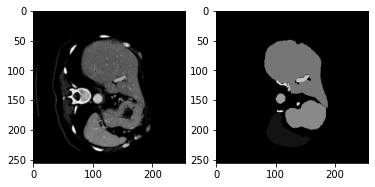

774

In [5]:
dataset = Nifti_Dataset(mode = "train",dim = 2)
idx = np.random.randint(0,len(dataset))
dataset.show(idx)
len(dataset)
#dataset.show_slices(0,dim = 2, organ_id = None)

## Define UNet

Use model from github, and define so it outputs one plane for each organ class

In [0]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=14,
        depth=4,
        wf=5,
        padding=True,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

        innum = 1000
        midnum = 100
        outnum = 4*n_classes
        self.reg = nn.Sequential(
            nn.BatchNorm1d(innum),
            nn.Linear(innum,midnum),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(midnum,outnum),
            nn.Sigmoid()
        )


    def forward(self, x,BBOX = False):
        blocks = []
        
        # encoder
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        # decoder
        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        x = torch.sigmoid(self.last(x))

        return x


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Define Assorted Functions for Training and Testing

Critical to realize here is that we can either define a UNet that has 1 output channel (positive negative) or 13 output channels (each class). For now, we'll start with just one output map, and see where that gets us

In [0]:
def refactor_inputs(x,y,mode = "all_organs",id_num = 1,num_outputs = 13):
  """
  Modifies inputs for different segmentation-style tasks with the goal of training
  the same network for progressively more difficult tasks
  mode - foreground,all_organs,edges,organ_slices, bboxes 
  x - batch x 1 x 256x256 image
  y - batch x 1 x 256 x 256 image with integer value classes
  id_num - int - specifies organ to look for for single organ mode
  num_outputs - specifies number of output maps to make
  """
  ones = torch.ones(y.shape)
  zeros = torch.zeros(y.shape)
  y = (y/0.0039).floor()

  if mode == "organ_slices":
    all_slices = []
    for i in range(0,num_outputs+1):
      y1 = torch.where((y.int() == i),ones,zeros)
      all_slices.append(y1)
    target = torch.cat(all_slices,dim = 1)
   
  return x,target

def test_slice(dataset,model,idx,device,refactor_mode):
  x,y = dataset[idx]
  x = x.unsqueeze(0)
  y = y.unsqueeze(0)

  x,y_new = refactor_inputs(x,y,mode = refactor_mode)
  x = x.to(device)

  output = model(x)
  output = torch.argmax(output,dim = 1).unsqueeze(0) # so we don't get weird rounding artifacts
  output = output.cpu()
  output = output.data.numpy()
  
  # inputs
  plt.figure(figsize = (10,10))
  plt.subplot(221)
  plt.title("Inputs")
  plt.imshow(x.data.cpu().numpy()[0][0],cmap = "gray")
  plt.clim(0,1)

  # original labels
  plt.subplot(222)
  plt.imshow(y[0][0],cmap = "gray")
  plt.title("Original Labels")

  # outputs
  output = output[0]
  stacked = torch.zeros((output[0].shape))
  for i in range(0,len(output)):
    stacked += output[i]*(i)
    #print(output[i].mean())
  output = stacked
  plt.subplot(223)
  plt.imshow(output,cmap = "gray")
  plt.clim(0,13)
  plt.title("Outputs")
 

  # target
  y_new = y_new[0]
  stacked = torch.zeros((y_new[0].shape))
  for i in range(0,len(y_new)):
    stacked += y_new[i]*(i)
  y_new = stacked
  plt.subplot(224)
  plt.imshow(y_new,cmap = "gray")
  plt.title("Correct Labels")
  plt.clim(0,13)
  plt.show()


def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

  return model,optimizer,epoch,all_losses,all_accs

## Loss Functions
Try to encourage various aspects of desired outputs

In [0]:
class Sparse_Loss(nn.Module):   
  """
  Penalizes for all non-zero outputs
  """     
  def __init__(self):
      super(Sparse_Loss,self).__init__()
      self.relu = nn.ReLU()
  
  def forward(self,output):  
      buffered = output#-0.01
      penalty = self.relu(buffered)
      return penalty.mean()

class Dice_Loss(nn.Module):        
    def __init__(self):
        super(Dice_Loss,self).__init__()
        
    def forward(self,output,target,epsilon = 1e-07):
        """ Compute the bbox iou loss for target vs output using tensors to preserve
        gradients for efficient backpropogation"""
        numerator = 2.0*torch.mul(output,target) 
        denominator = output + target
        dice = torch.div(numerator,denominator)
        #print (dice.shape)
        #loss =  1.0 -(torch.sum(dice)/torch.numel(dice))
        #print("{} / {} = {}".format(numerator.sum(),denominator.sum(),loss))

        loss = 1.0 - torch.sum(numerator)/torch.sum(denominator)
        #print (loss.shape)
        #print (loss)
        return loss

class WeightedBCELoss(nn.Module):
  def __init__(self):
        super(WeightedBCELoss,self).__init__()
        
  def forward(self,target,output,positive_weight = 10):
    """ Compute Binary Cross Entropy Loss for targets and inputs
        weights each output map by the inverse relative prevalence of that 
        class label in the target, and also applies a weighting factor to 
        positive labels over negative ones"""

    # calculate sums of each class in batch
    min_val = 10 # otherwise,absent classes would be weighted infinitely
    class_sums = torch.sum(torch.sum(torch.sum(target,dim = 3),dim = 2),dim = 0) + min_val
    class_weights = torch.div(torch.ones(class_sums.shape),class_sums)
    sum_weights = torch.sum(class_weights)
    class_weights = class_weights / sum_weights
    class_weights = class_weights.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    class_weights = class_weights.repeat(target[:,:1,:,:].shape)
    # calculate error from true positives - will be zero unless target is 1
    pos_loss = -torch.mul(target,torch.log2(output))
    print(pos_loss.sum())
    # calculate error from true negatives - will be zero unless target is 0 
    neg_loss = -torch.mul(1.0-target,torch.log2(1.0-output))
    print(neg_loss.sum())

    unweighted_loss = neg_loss + positive_weight*pos_loss
    loss = torch.mul(unweighted_loss,class_weights)
    loss = loss.mean()
    return loss

In [120]:
loss = WeightedBCELoss()

x,y = dataset[0]
x = x.unsqueeze(0).repeat(8,1,1,1)
y = y.unsqueeze(0).repeat(8,1,1,1)
x,y = refactor_inputs(x,y,mode = "organ_slices")
y2 = (torch.rand((y.shape))+0.001)*0.99
loss(y,y2)


tensor(757177.4375)
tensor(9418853.)


tensor(0.0987)

tensor(0.)


## Basic Training Loop
All special modifications should be done by means of refactor_inputs

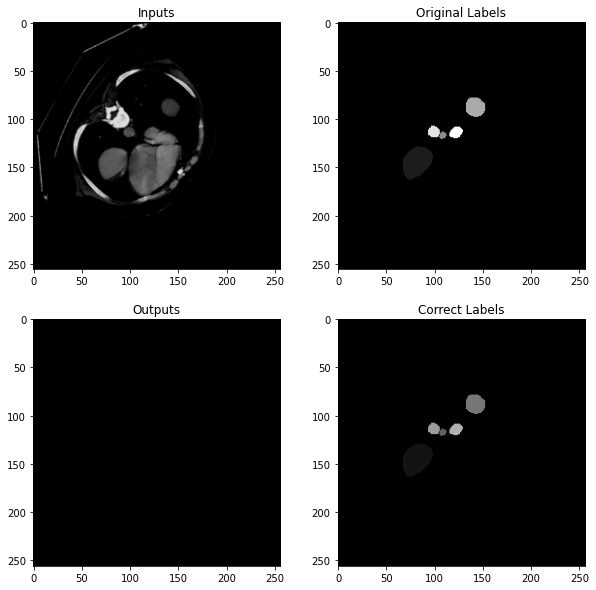

In [40]:
idx = random.randint(0,len(dataset))
test_slice(dataset,model,idx,device,"organ_slices")

##test = torch.Tensor([[1,2,4],[3,2,6]])
#out = torch.where(test == 2,torch.ones(test.shape),torch.zeros(test.shape))
#print (out)

In [0]:
def train_model(model, optimizer, scheduler,loss_function,loss_function2,
                    dataset,device, num_epochs=5, start_epoch = 0,
                    all_losses = None,all_accs = None,refactor_mode = "foreground"):
        """
        Alternates between a training step and a validation step at each epoch. 
        Validation results are reported but don't impact model weights
        """
        loss3 = Sparse_Loss()

        # define once storing all metrics
        if all_losses == None:
          all_losses = {
                  'train':[],
                  'val':[]
          }
          all_accs = {
                  "train":[],
                  "val":[]
                  }
        avg_acc = 0
        
        # create testloader for val_dataset (loader is made each epoch)
        params = {'batch_size': 8,
              'shuffle': True,
              'num_workers': 0,
              'drop_last' : True
              }

        # One epoch covers all data once
        for epoch in range(start_epoch,num_epochs):
            print("")

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                
                if phase == 'train':
                  # Set model to training mode
                  model.train()
                  # Step scheduler  
                  if epoch > 0:
                    scheduler.step(avg_acc)
                  # set dataset and dataloader to training mode
                  dataset.mode = "train"
                  loader = data.DataLoader(dataset,**params)
                    
                elif phase == "val":
                  model.eval()   # Set model to evaluate mode
                  dataset.mode = "val"
                  loader = data.DataLoader(dataset,**params)

                # metrics summaries per epoch
                count = 0
                total_loss = 0
                total_acc = 0

                # Iterate over each data item                                                        
                for input, target in loader:

                    input,target = refactor_inputs(input,target,mode = refactor_mode)

                    input = input.to(device)
                    target = target.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                      output = model(input)

                      # to prevent overlearning negatives
                      

                      # get loss and accuracy
                      loss = loss_function(output.float(),target.float())
                      acc = 1.0 - loss

                     # for i in range(0,len(output[1])):
                     #   loss = loss + loss_function2(output[:,i,:,:].float(),target[:,i,:,:].float())
                     # loss = loss + 3*loss3(output)
                      
                      #backprop loss
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()
                    
                    # verbose update
                    count += 1
                    total_acc += acc
                    total_loss += loss.item()
                    if count % 20 == 0:
                      print("{} epoch {} batch {} -- Loss: {:03f} -- Accuracy {:02f}".format(phase,epoch,count,loss.item(),acc))
                
                avg_acc = total_acc/count
                avg_loss = total_loss/count
                print("Epoch {} avg {} loss: {:05f}  acc: {}".format(epoch, phase,avg_loss,avg_acc))
                all_losses[phase].append(total_loss)
                all_accs[phase].append(avg_acc)

                if epoch % 1 == 0:
                  
                  # plot an output
                  idx = np.random.randint(0,len(dataset))
                  try:
                    test_slice(dataset,model,idx,device,refactor_mode)
                  except:
                    pass

                  # save a checkpoint
                  PATH = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNet_{}.pt".format(epoch)
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      "losses":all_losses,
                      "accs":all_accs
                      }, PATH)
                  
                torch.cuda.empty_cache()
                del loader
                
        return model , all_losses,all_accs

## Run Training Loop

In [39]:
if __name__ == "__main__":
  dim = 2
  
  try:
      torch.multiprocessing.set_start_method('spawn')    
  except:
      pass

  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  torch.cuda.empty_cache()   
  
  #%% Create Model
  #try:
  #  model
  #except:
  #  model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
  #  in_channels=3, out_channels=1, init_features=32, pretrained=True)
  
  model = UNet()
  print ("Model loaded.")
  model = model.to(device)

  #%% Create datasets
  try:
      dataset
  except:
      dataset = Nifti_Dataset(mode = "train", dim = dim)
      print("Loaded dataset on dimension {}".format(dim))

  start_epoch = -1
  num_epochs = 200

  loss = Dice_Loss()
  loss2 = nn.BCELoss()

  optimizer = optim.SGD(model.parameters(), lr= 0.1,momentum = 0.1)    
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.333333, mode = "max", patience = 3,verbose=True)

  #checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNET11_foreground_e22.pt"
  checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNET114_slices_e19.pt"
  #checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/possibly_worth_saving2.pt"

  if checkpoint:
    model,optimizer,_,all_losses,all_accs = load_model(checkpoint,model, optimizer)
    print("Reloaded checkpoint {}.".format(checkpoint))
  if False:    
  # train model
      print("Beginning training on {}.".format(device))
      model,all_losses,all_accs = train_model(model,
                                              optimizer,
                                              scheduler,
                                              loss,
                                              loss2,
                                              dataset,
                                              device,
                                              num_epochs, 
                                              start_epoch+1,
                                              all_losses= None,
                                              all_accs= None,
                                              refactor_mode = "organ_slices")


  torch.cuda.empty_cache()  

Model loaded.
Reloaded checkpoint /content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNET114_slices_e19.pt.


In [0]:
del  model  